# Plotting Tools
Some basic plotting tools used throughout the notebook.

In [1]:
# Plot 2 images side-by-side
def plot_sbs(img1, img2):
    
    plt.figure(figsize = (16, 20))
    plt.subplot(1,2,1)
    plt.imshow(img1)
    plt.subplot(1,2,2)
    plt.imshow(img2)
    

# Extract Sample Images from Challenge Video
Here, I'll grab some images for use throughout this notebook.

In [4]:
from moviepy.editor import VideoFileClip

# Times for frames to extract
times = [4.0,16.1]

clear1 = None
clip1 = VideoFileClip("challenge_video.mp4")

raw_imgs = []

for time in times:
    raw_imgs.append(clip1.get_frame(time))
    

# Camera Calibration

In [2]:
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import glob

# Read in images
cal_files = glob.glob('camera_cal/*.jpg')

cal_imgs = []
for file in cal_files:
    cal_imgs.append(mpimg.imread(file)) #RGB image
    
"""
for img in cal_imgs:
    plt.figure()
    plt.imshow(img)
"""

'\nfor img in cal_imgs:\n    plt.figure()\n    plt.imshow(img)\n'

In [3]:

def cal_camera(imgs, nc = (9,6), plots = False):
    
    objpoints = []
    imgpoints = []
    
    objp = np.zeros((nc[0]*nc[1], 3), np.float32)
    objp[:,:2] = np.mgrid[0:nc[0], 0:nc[1]].T.reshape(-1,2)
    
    shape = imgs[0].shape[1::-1]
    
    for img in imgs:
        # Convert to grayscale
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, nc, None)

        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

            #img = cv2.drawChessboardCorners(img, nc, corners, ret)
            #plt.figure()
            #plt.imshow(img)
    
    retval, matrix, distortion, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
    
    return matrix, distortion



save_mtx = 'camera_cal/cam_cal_mtx.p'
save_dist = 'camera_cal/cam_cal_dist.p'

action = 'load'

if(action == 'gen'):
    mtx, dist = cal_camera(cal_imgs)
    pickle.dump(mtx, open(save_mtx, "wb" ))
    pickle.dump(dist, open(save_dist, "wb" ))
elif(action == 'load'):
    with open(save_mtx, mode='rb') as f:
        mtx = pickle.load(f)
    with open(save_dist, mode='rb') as f:
        dist = pickle.load(f)
else:
    print("Choose whether to generate or load camera calibration data.")
    

# Undistort Images
The first of the raw images was selected specifically because it was easy to see the camera distortion when travelling under the overpass. 

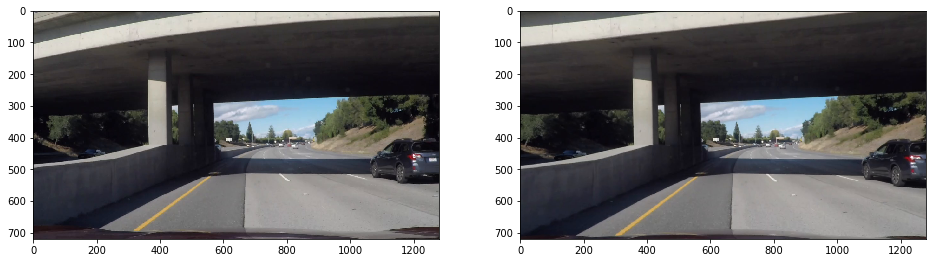

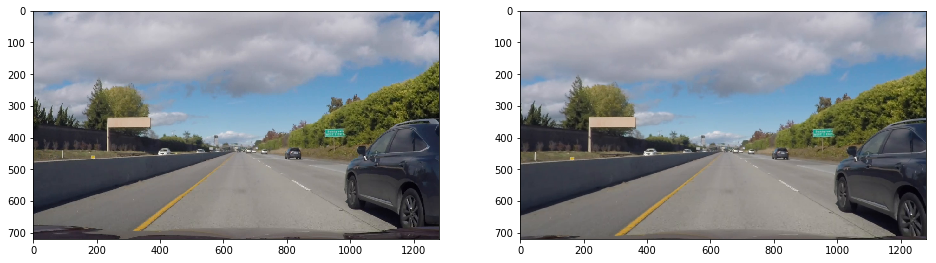

In [5]:
# Undistort an image

def undistort(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

undist_imgs = []


for img in raw_imgs:
    
    undist_imgs.append(undistort(img, mtx, dist))

plot_sbs(raw_imgs[0], undist_imgs[0])
plot_sbs(raw_imgs[1], undist_imgs[1])

# Perspective Transform

In theory, any image (of the size that we're using, at least) that has been corrected for distortion could be used to determine how to warp the perspective to plot lane lines. Therefore, I'll do this with one of the provided "straight" line images, since frames with straight lines are scarce in the challenge video.

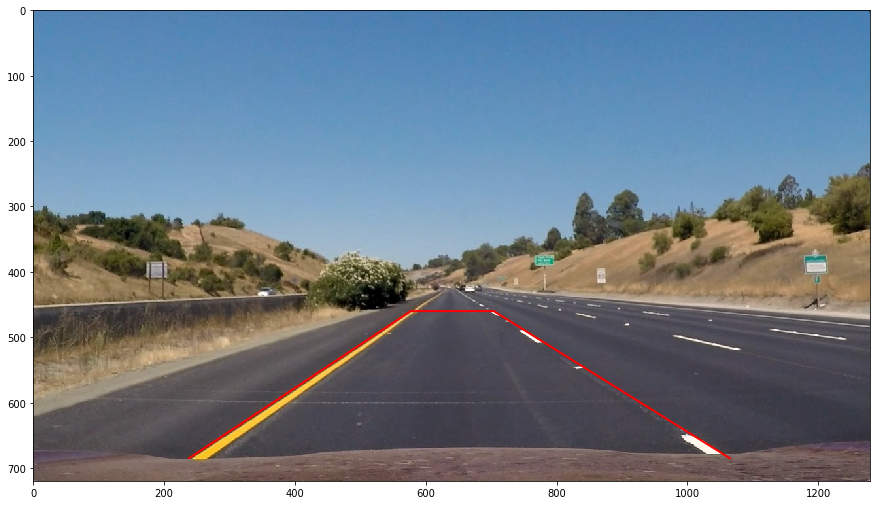

In [6]:
# Grab an image to use for calibrating the perspective warp
strt_img = mpimg.imread('test_images/straight_lines1.jpg')
shp = strt_img.shape

# Pick out some points - these were fine-tuned by hand
xpnts = [238, 577, 704, 1065]
ypnts = [shp[0]-35, 460, 460, shp[0]-35,]

# Plot points
plt.figure(figsize = (15,25));
plt.imshow(strt_img);
plt.plot(xpnts, ypnts, 'r-', linewidth=2);


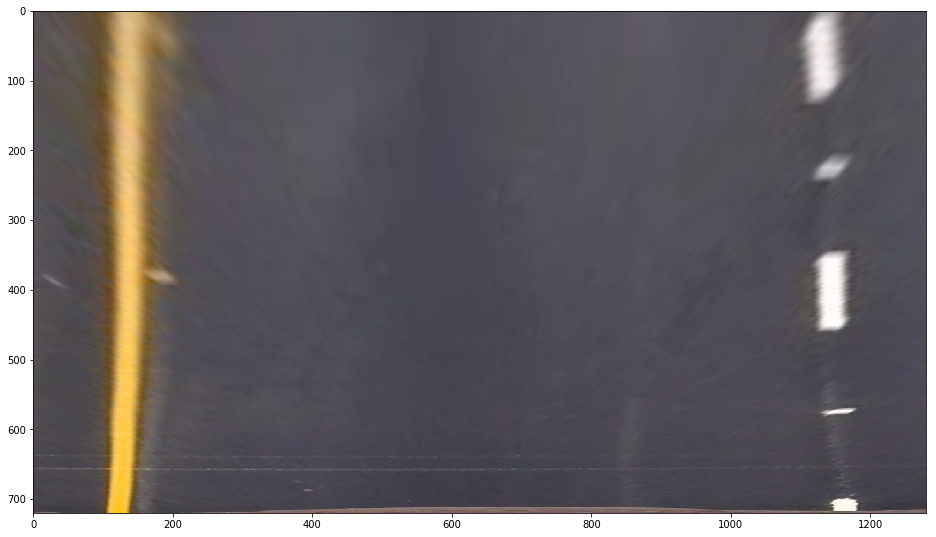

In [7]:
# Define a warping function to do the perspective transform
def warpPers(img):
    
    #Hard-coding the values here
    xpnts = [238, 577, 707, 1066]
    ypnts = [720-35, 460, 460, 720-35,]
    
    # Reshape to the format required by cv2
    srcx = np.array(xpnts)[np.newaxis].T
    srcy = np.array(ypnts)[np.newaxis].T
    src = np.concatenate((srcx, srcy), axis=1).astype(np.float32)
    
    ofst = 100
    dst = np.float32([[ofst, shp[0]], [ofst, 0], [shp[1]-ofst, 0], [shp[1]-ofst, shp[0]]])

    # Warp
    M = cv2.getPerspectiveTransform(src,dst)
    warped = cv2.warpPerspective(img, M, (shp[1], shp[0]))
    
    return warped

plt.figure(figsize=(16, 24));
plt.imshow(warpPers(strt_img));

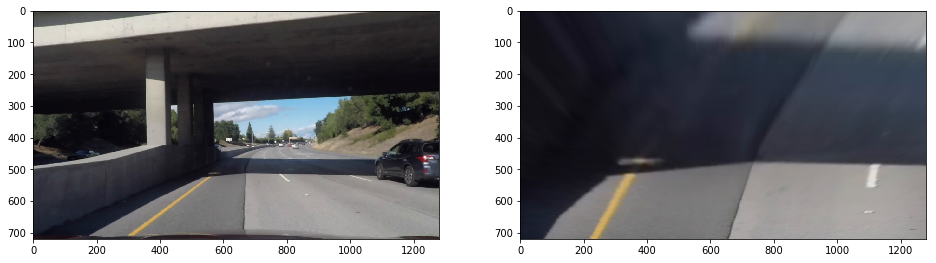

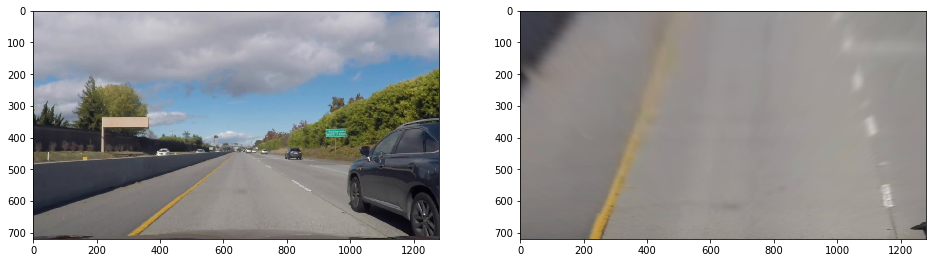

In [8]:
# Try on a few images from the video

plot_sbs(undist_imgs[0], warpPers(undist_imgs[0]))
plot_sbs(undist_imgs[1], warpPers(undist_imgs[1]))